In [1]:
import pandas as pd
import numpy as np
import catboost
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

## Data preprocessing

In [2]:
df_for_learning = pd.read_csv("train.csv")
df_for_test = pd.read_csv("test.csv")
df_test_id = df_for_test["Id"]

In [3]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

In [4]:
df_for_learning = clean(df_for_learning)
df_for_test = clean(df_for_test)

In [5]:
df_for_learning.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df_for_learning.shape

(1460, 81)

Analysis of the missing data

In [7]:
data_miss_values_sum = df_for_learning.isna().sum().sort_values(ascending=False)
data_miss_values_mean = df_for_learning.isna().mean().sort_values(ascending=True)
miss_values_summary = pd.concat([data_miss_values_sum,data_miss_values_mean], axis=1, keys=['Total', 'Percentage'])
miss_values_summary.head(20)

,Total,Percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [8]:
# choose features with most numbers of missing values
# take a look at them
columns_with_many_missings_number = 5
percentage_threshhold = 0.4
columns_with_many_missings = list(miss_values_summary[miss_values_summary['Percentage']>percentage_threshhold].index)
columns_with_many_missings

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

In [9]:
for column in columns_with_many_missings:
    print(f'Feature {column}')
    display(df_for_learning[column].value_counts(dropna=False))

Feature PoolQC


NaN    1453
Gd        3
Fa        2
Ex        2
Name: PoolQC, dtype: int64

Feature MiscFeature


NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64

Feature Alley


NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

Feature Fence


NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

Feature FireplaceQu


NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: FireplaceQu, dtype: int64

In [10]:
def get_num_features_for_train(df):
    numerical_features = list(df.select_dtypes(include=['int64','float64']).columns)
    if 'SalePrice' in numerical_features:
        numerical_features.remove('SalePrice')
    return numerical_features

In [11]:
# function for replacing NaNs with means and modes 
# (depends on dtype of variable)
def remove_nans_custom(df):
    obj_features = list(df.select_dtypes(include=['object']).columns)
    int_features = get_num_features_for_train(df)
#     df[int_features] = df[int_features].apply(lambda x: x.fillna(x.interpolate(method='spline',order = 3)))
    df[int_features] = df[int_features].apply(lambda x: x.fillna(x.fillna(x.median())))
    df[obj_features] = df[obj_features].apply(lambda x: x.fillna(x.value_counts().index[0]))
    return df

Remove all columns with too many NaNs and replace in remaining ones NaN with means and modes

In [12]:
df_for_learning_no_missing = df_for_learning.drop(columns = columns_with_many_missings)
df_for_test_no_missing = df_for_test.drop(columns = columns_with_many_missings)
df_for_learning_no_missing = remove_nans_custom(df_for_learning_no_missing)
df_for_test_no_missing = remove_nans_custom(df_for_test_no_missing)


Let's remove all features which are almost constant (consist more than 95% of a certain value)

In [13]:
def get_almost_constant_columns(df, type_of_columns, threshold = 0.95):
    almost_constant_column = [feature for feature in df.select_dtypes(include = type_of_columns).columns
                 if df[feature].value_counts(normalize=True).values[0] > threshold]
    return almost_constant_column

In [14]:
for feature in df_for_learning_no_missing.select_dtypes(include=['object']).columns:
    threshold = 0.95
    homogenity_rate = df_for_learning_no_missing[feature].value_counts(normalize=True)[0]
    if homogenity_rate > threshold:
        print("feature: {}, homogenity rate: {} ".format(feature, homogenity_rate))
        print(df_for_learning_no_missing[feature].value_counts())

feature: Street, homogenity rate: 0.9958904109589041 
Pave    1454
Grvl       6
Name: Street, dtype: int64
feature: Utilities, homogenity rate: 0.9993150684931507 
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
feature: Condition2, homogenity rate: 0.9897260273972602 
Norm      1445
Feedr        6
PosN         2
RRNn         2
Artery       2
RRAn         1
PosA         1
RRAe         1
Name: Condition2, dtype: int64
feature: RoofMatl, homogenity rate: 0.9821917808219178 
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Roll          1
Membran       1
ClyTile       1
Name: RoofMatl, dtype: int64
feature: Heating, homogenity rate: 0.9780821917808219 
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64
feature: GarageQual, homogenity rate: 0.9534246575342465 
TA    1392
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64
feature: GarageCond, homogenity rate: 0.963

In [15]:
# # remove all columns which consist on 95%+ of the same value
almost_constant_column = get_almost_constant_columns(df_for_learning_no_missing,['object'], threshold=0.95)
almost_constant_column

['Street',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Heating',
 'GarageQual',
 'GarageCond']

In [16]:
df_for_learning_no_missing.drop(columns = almost_constant_column,inplace=True)
df_for_test_no_missing.drop(columns = almost_constant_column,inplace=True)

Analyze categorical features, which values they do contain

In [17]:
thrs_max = 0.95
thrs_min = 0.85
for feature in df_for_learning_no_missing.select_dtypes(include=['object']).columns:
    homogenity_rate = df_for_learning_no_missing[feature].value_counts(normalize=True)[0]
    if (homogenity_rate <= thrs_max) and (homogenity_rate > thrs_min):
        print("feature: {}, homogenity rate: {}".format(feature, homogenity_rate))
        print(df_for_learning_no_missing[feature].value_counts())

feature: LandContour, homogenity rate: 0.897945205479452
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
feature: LandSlope, homogenity rate: 0.9465753424657535
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
feature: Condition1, homogenity rate: 0.863013698630137
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64
feature: ExterCond, homogenity rate: 0.8780821917808219
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64
feature: BsmtCond, homogenity rate: 0.9232876712328767
TA    1348
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64
feature: BsmtFinType2, homogenity rate: 0.8863013698630137
Unf    1294
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64
feature: CentralAir, homogenity rate: 0.934931506849315
Y    1365
N      95
Name: Cent

Some of them may be binarized (features consisting between 80 and 95% of the same value)

Function beneath had been made for that purpose 

In [18]:
def binarize_features(df_tr, df_test, type_of_columns, thrs_max = 0.95, thrs_min = 0.85):
    features_to_binarize = []
    for feature in df_tr.select_dtypes(include = type_of_columns).columns:
        homogenity_rate = df_tr[feature].value_counts(normalize=True).values[0]
        if (homogenity_rate <= thrs_max) and (homogenity_rate > thrs_min):
            features_to_binarize.append(feature)
            most_freq_el = df_tr[feature].value_counts().index[0]
            new_feature_name = "{}_is_{}".format(feature, str(most_freq_el))
            df_tr[new_feature_name] = df_tr[feature].apply(lambda x: 1 if x == most_freq_el else 0 )
            df_tr.drop(columns = [feature],inplace=True)
            df_test[new_feature_name] = df_test[feature].apply(lambda x: 1 if x == most_freq_el else 0 )
            df_test.drop(columns = [feature],inplace=True)
    return features_to_binarize

In [19]:
# cols_to_binarize = binarize_features(df_for_learning_no_missing, df_for_test_no_missing, ['object'], thrs_max=0.95, thrs_min =0.85)

Numerical features should be analyzed, maybe they can be binarized

In [20]:
for feature in df_for_learning_no_missing.select_dtypes(include = ['int64','float64']).columns:
    threshold = df_for_learning_no_missing[feature].value_counts(normalize=True).values[0]
    if  (threshold > 0.85):
        print(feature)
        print(df_for_learning_no_missing[feature].value_counts(normalize=True))

BsmtFinSF2
0       0.885616
180     0.003425
374     0.002055
117     0.001370
391     0.001370
          ...   
215     0.000685
211     0.000685
210     0.000685
208     0.000685
1474    0.000685
Name: BsmtFinSF2, Length: 144, dtype: float64
LowQualFinSF
0      0.982192
80     0.002055
360    0.001370
392    0.000685
528    0.000685
515    0.000685
514    0.000685
513    0.000685
481    0.000685
479    0.000685
473    0.000685
420    0.000685
397    0.000685
390    0.000685
53     0.000685
384    0.000685
371    0.000685
234    0.000685
232    0.000685
205    0.000685
156    0.000685
144    0.000685
120    0.000685
572    0.000685
Name: LowQualFinSF, dtype: float64
BsmtHalfBath
0    0.943836
1    0.054795
2    0.001370
Name: BsmtHalfBath, dtype: float64
KitchenAbvGr
1    0.953425
2    0.044521
3    0.001370
0    0.000685
Name: KitchenAbvGr, dtype: float64
EnclosedPorch
0      0.857534
112    0.010274
96     0.004110
120    0.003425
192    0.003425
         ...   
170    0.000685
169 

You see, there are many feaures can be binarized or totally removed

In [21]:
almost_constant_column_int = get_almost_constant_columns(df_for_learning_no_missing,['int64','float64'], threshold = 0.95)
almost_constant_column_int

['LowQualFinSF', 'KitchenAbvGr', 'Threeseasonporch', 'PoolArea', 'MiscVal']

In [22]:
df_for_learning_no_missing.drop(columns = almost_constant_column_int, inplace = True)
df_for_test_no_missing.drop(columns = almost_constant_column_int, inplace = True)

Binarize all numerical feauters with a value's dominance

In [23]:
#binarize_features(df_for_learning_no_missing, df_for_test_no_missing, ['int64','float64'])

Let's take a look how SalePrice depends on other columns

Categorical features:

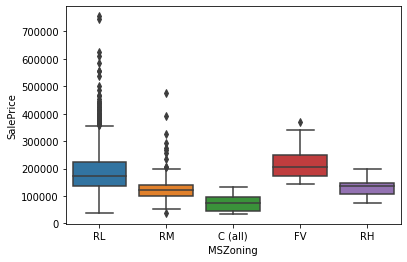

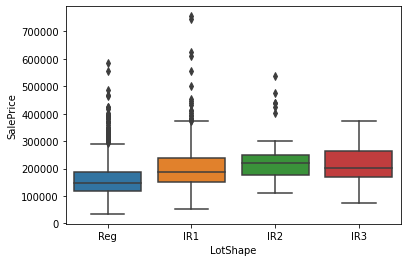

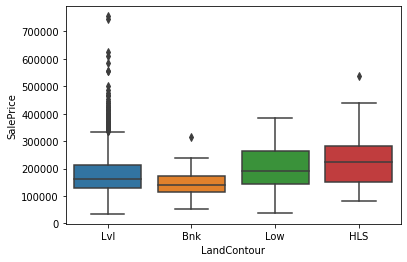

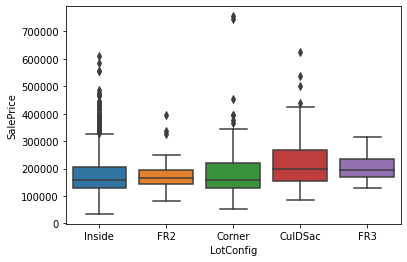

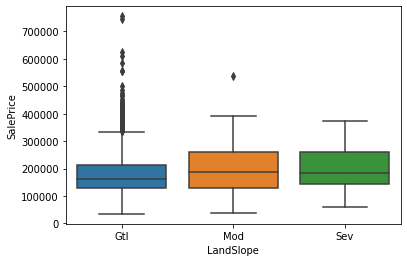

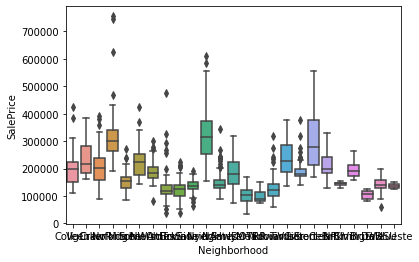

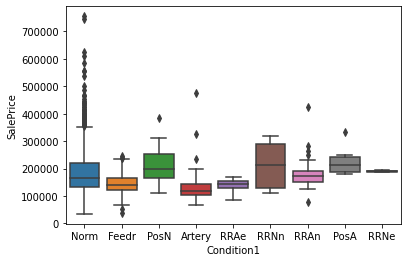

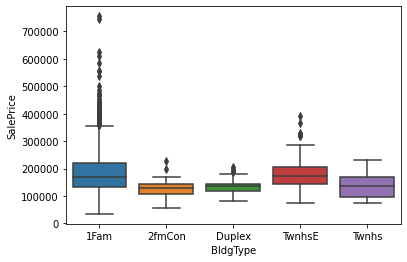

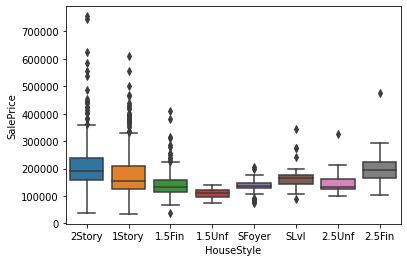

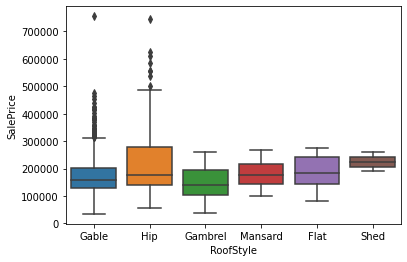

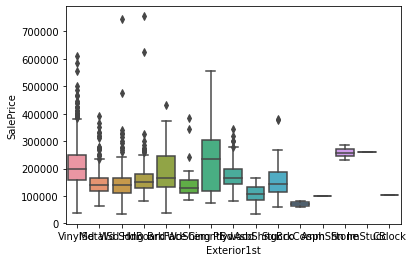

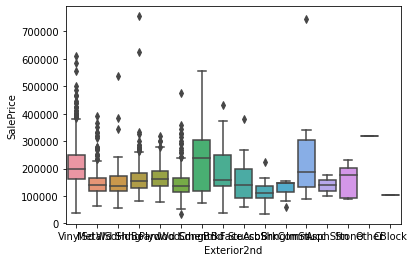

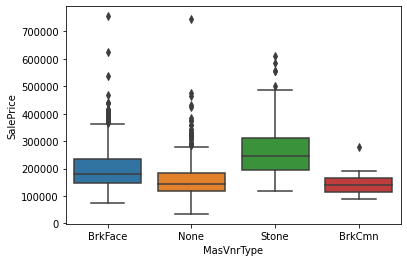

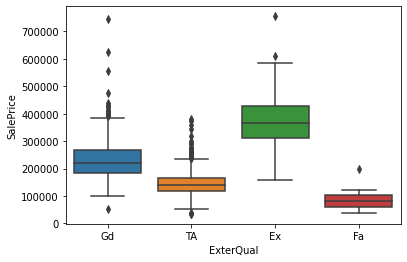

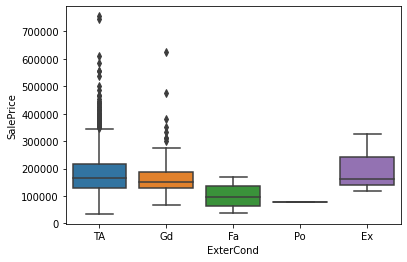

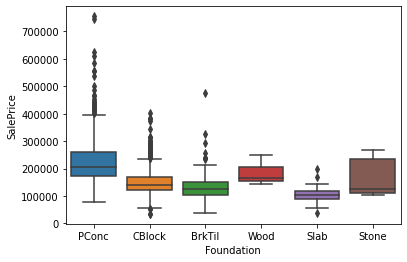

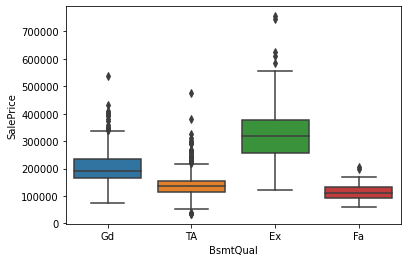

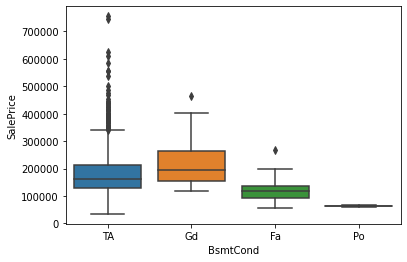

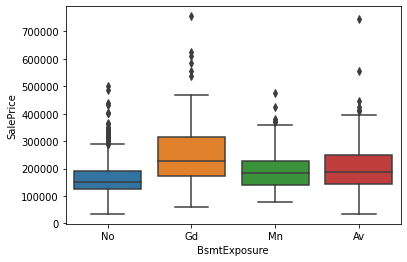

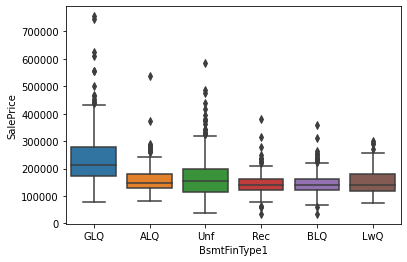

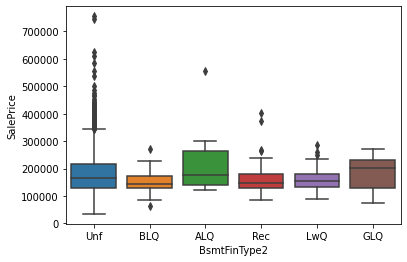

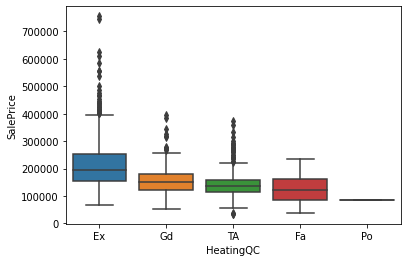

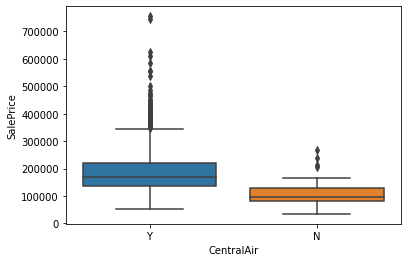

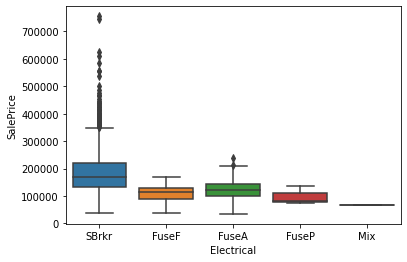

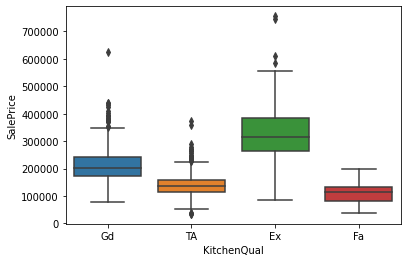

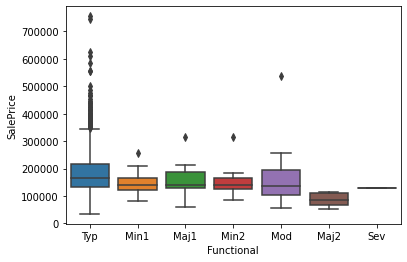

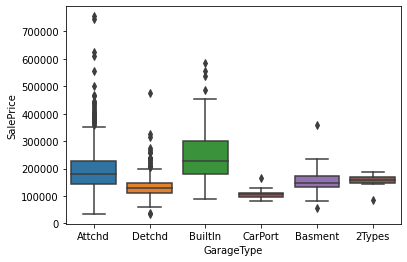

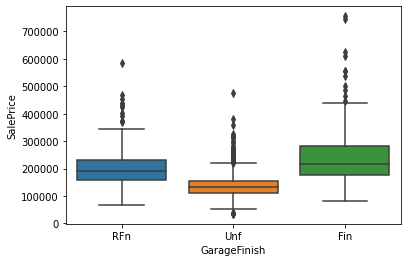

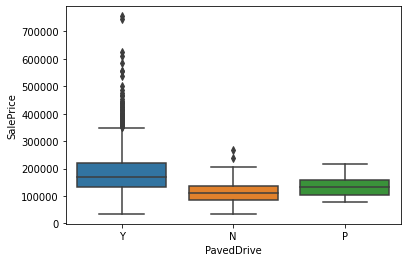

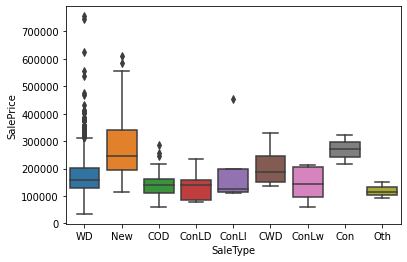

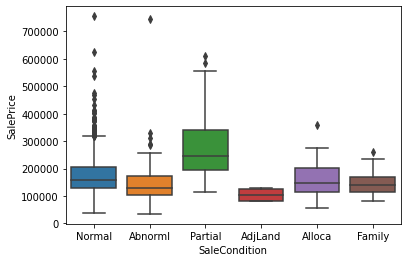

In [24]:
for feature_obj in df_for_learning_no_missing.select_dtypes(include=['object']).columns:
    sns.boxplot(x=df_for_learning_no_missing[feature_obj], y=df_for_learning_no_missing['SalePrice'], data=df_for_learning)
    plt.show()

Numerical features:

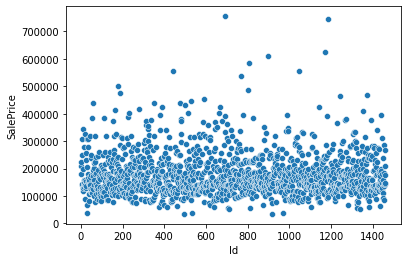

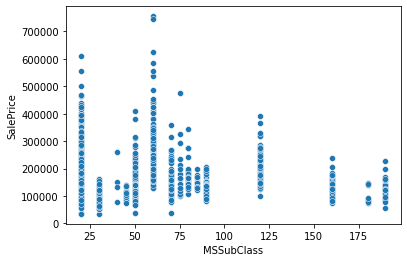

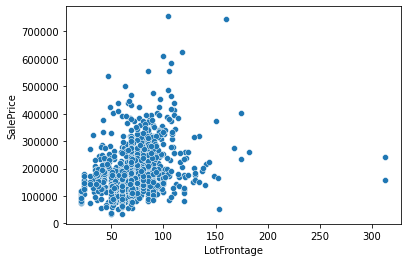

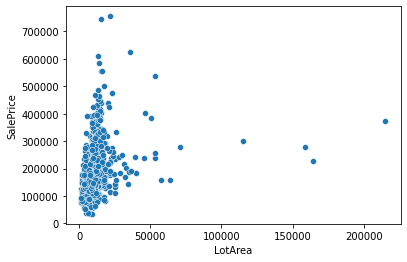

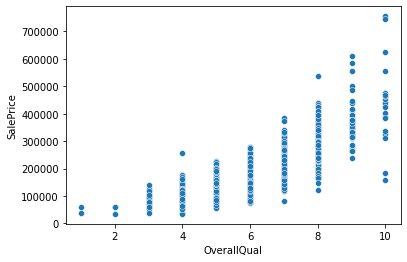

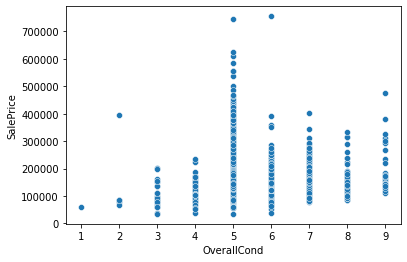

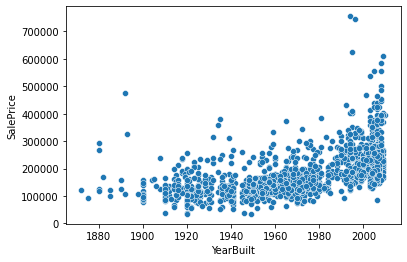

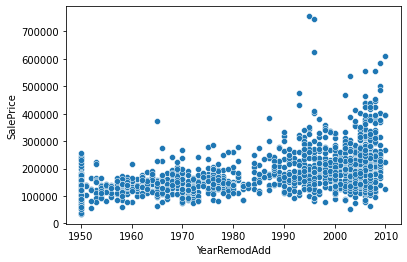

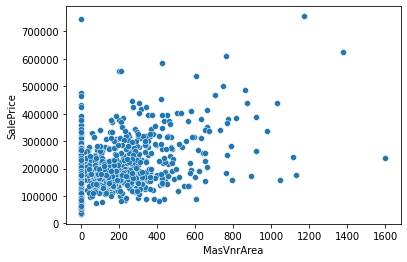

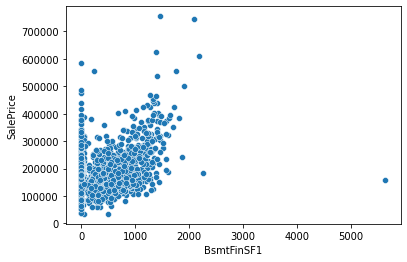

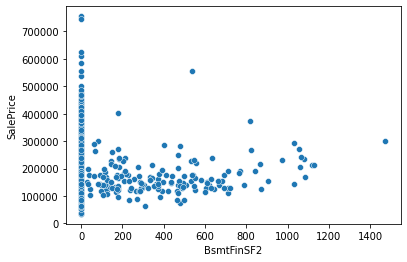

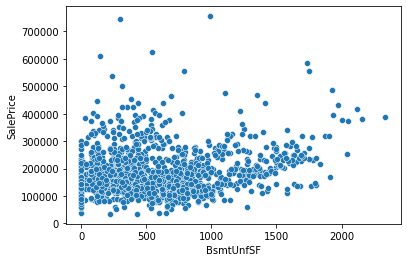

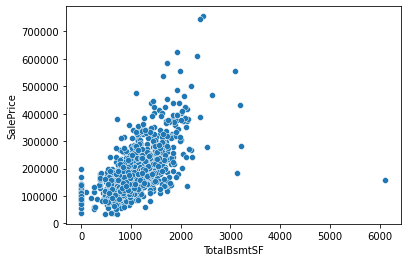

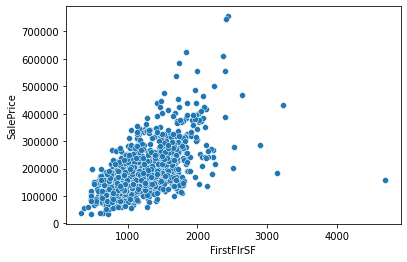

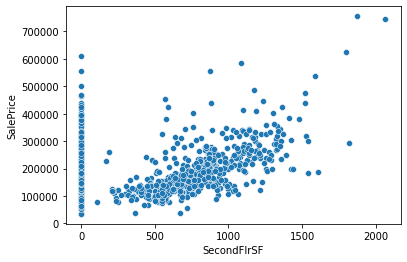

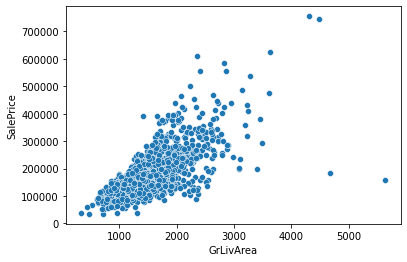

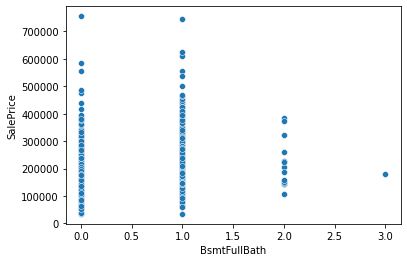

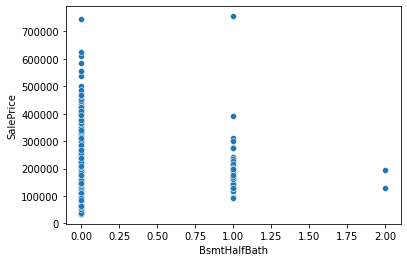

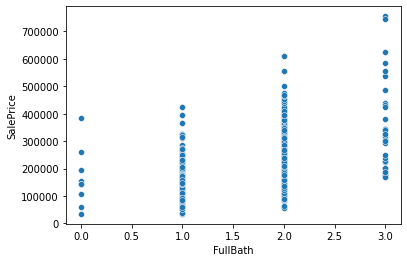

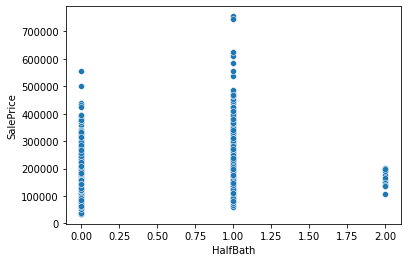

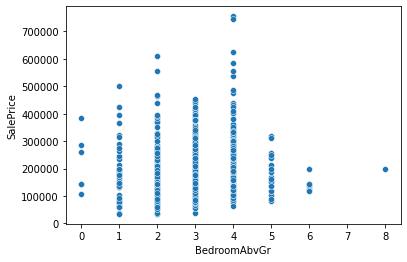

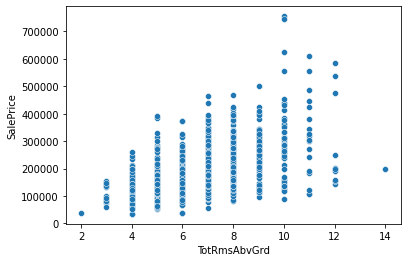

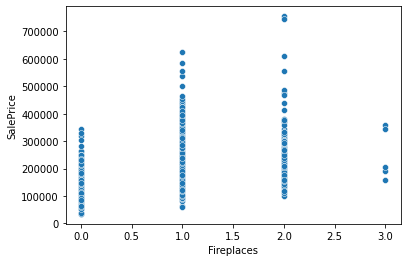

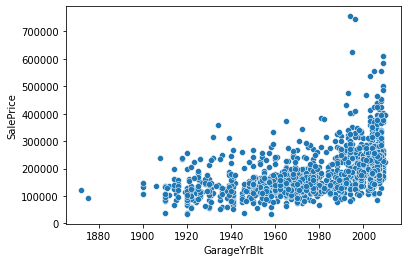

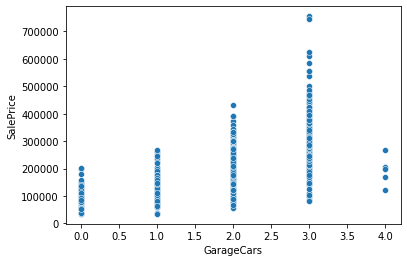

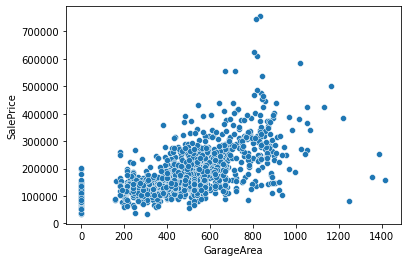

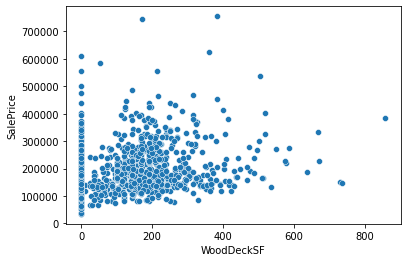

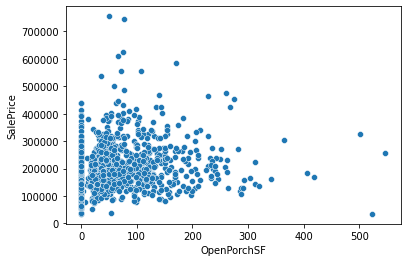

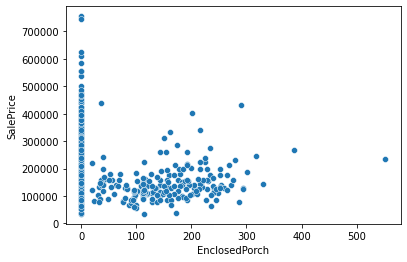

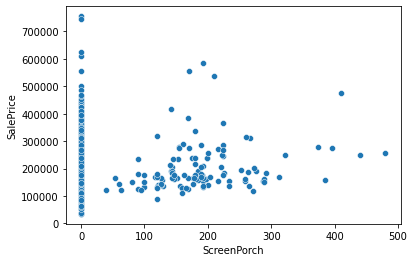

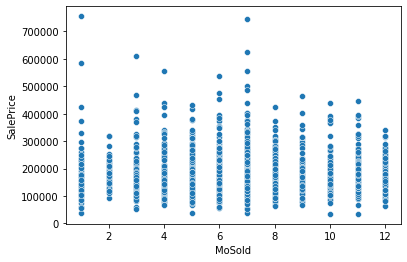

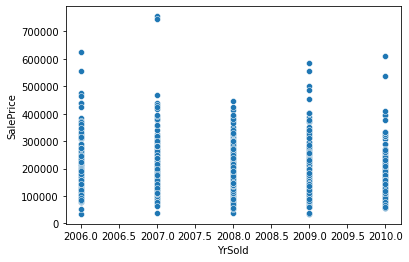

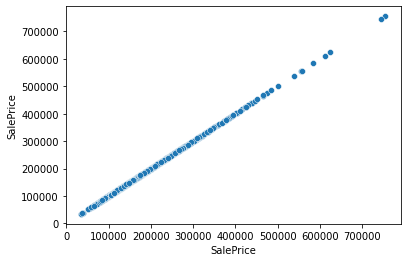

In [25]:
for feature_obj in df_for_learning_no_missing.select_dtypes(include=['int64','float64']).columns:
    sns.scatterplot(x=df_for_learning_no_missing[feature_obj], y=df_for_learning_no_missing['SalePrice'])
    plt.show()

Looking at the graphs above we may see outliers just visually and remove them

In [26]:
# from sklearn.ensemble import IsolationForest
# IsForest = IsolationForest(contamination = 0.03)
# outliers_train = IsForest.fit_predict(df_for_learning_no_missing[get_num_features_for_train(df_for_learning_no_missing)])
# df_for_learning_no_missing = df_for_learning_no_missing.loc[outliers_train==1]

In [27]:
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.HeatingQC != 'Po']
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.GrLivArea < 4500]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.SalePrice < 700000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.TotRmsAbvGrd < 14]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.OpenPorchSF < 500]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.WoodDeckSF < 800]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BedroomAbvGr < 8]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BsmtFullBath < 3]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BsmtFullBath < 3]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.FirstFlrSF < 4000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.TotalBsmtSF < 4000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BsmtFinSF1 < 5000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.MasVnrArea < 1500]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.LotArea < 100000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.LotFrontage < 200]

As we can also see, some numerical features may be transformed into categorical features, because they have only a short range of values

In [28]:
def numerical_to_object(df_tr, df_test):
    threshold = 30
    numerical_features = get_num_features_for_train(df_tr)
    for feature in numerical_features:
        if len(df_tr[feature].value_counts()) < threshold:
            df_tr[feature] = df_tr[feature].apply(lambda x: str(x))
            df_test[feature] = df_test[feature].apply(lambda x: str(x))
            
# numerical_to_object(df_for_learning_no_missing, df_for_test_no_missing)

## Feature engineering

In [29]:
from scipy.stats import anderson
from scipy.stats import kstest

In [30]:
def make_new_features(data_frame):
    data_frame['OverallQualSquared'] = data_frame['OverallQual'] * data_frame['OverallQual']
    data_frame['GarageYrBltSquared'] = data_frame['GarageYrBlt'] * data_frame['GarageYrBlt']
    data_frame['SecondFlrSFSquared'] = data_frame['SecondFlrSF'] * data_frame['SecondFlrSF']
    data_frame['YearBuiltSquared'] = data_frame['YearBuilt'] * data_frame['YearBuilt']
    return data_frame

In [31]:
# df_for_learning_no_missing = make_new_features(df_for_learning_no_missing)
# df_for_test_no_missing = make_new_features(df_for_test_no_missing)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

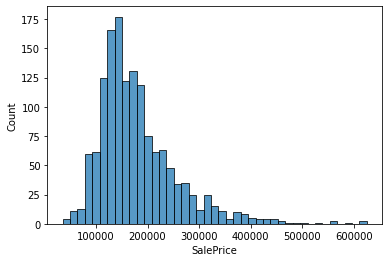

In [32]:
sns.histplot(df_for_learning_no_missing['SalePrice'])

In [33]:
kstest((df_for_learning_no_missing['SalePrice']),cdf = 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

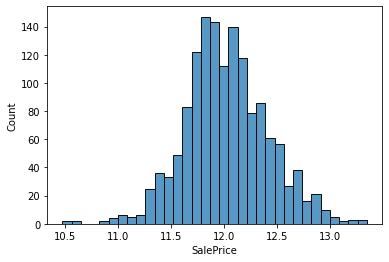

In [34]:
sns.histplot(np.log(df_for_learning_no_missing['SalePrice']))

In [35]:
df_for_learning_no_missing['SalePrice'] = np.log(df_for_learning_no_missing['SalePrice'])

In [36]:
kstest((df_for_learning_no_missing['SalePrice']),cdf = 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

## Correlation Analysis

In [37]:
from scipy.stats import f_oneway
from scipy.stats import spearmanr
from scipy.stats import pointbiserialr
from scipy.stats import kruskal

In [38]:
def my_kruskal(df, numeric_value_label, obj_value_label):
    grouped_data = df.groupby(obj_value_label)[numeric_value_label].apply(list)
    return kruskal(*grouped_data)

In [39]:
def get_obj_features_among_numeric(df_tr, df_test):
    obj_features = []
    max_features = 10
    numerical_features = get_num_features_for_train(df_tr)
    for feature in numerical_features:
        if len(set(df_tr[feature])) < max_features:
            obj_features.append(feature)
    return obj_features

obj_feats_among_num = get_obj_features_among_numeric(df_for_learning_no_missing, df_for_test_no_missing)

In [40]:
def my_anova(df, numeric_value_label, obj_value_label):
    grouped_data = df.groupby(obj_value_label)[numeric_value_label].apply(list)
    return f_oneway(*grouped_data)

In [41]:
# conf_level = 0.05
# not_important_obj_methods = []
# for feature in list(df_for_learning_no_missing.select_dtypes(include= ['object'])) + obj_feats_among_num:
#     anova_result = my_anova(df_for_learning_no_missing, 'SalePrice', feature)
#     if anova_result[1] > conf_level:
#         not_important_obj_methods.append(feature)
#         print("Feature: {}, anova results: {}".format(feature, anova_result))

In [42]:
conf_level = 0.05
not_important_obj_methods = []
for feature in list(df_for_learning_no_missing.select_dtypes(include= ['object'])) + obj_feats_among_num:
    kruskal_result = my_kruskal(df_for_learning_no_missing, 'SalePrice', feature)
    if kruskal_result[1] > conf_level:
        not_important_obj_methods.append(feature)
        print("Feature: {}, kruskal_results: {}".format(feature, kruskal_result))

Feature: LandSlope, kruskal_results: KruskalResult(statistic=2.1805356075431392, pvalue=0.3361264657171103)
Feature: BsmtFinType2, kruskal_results: KruskalResult(statistic=10.150016618401311, pvalue=0.07109448451069308)
Feature: BsmtHalfBath, kruskal_results: KruskalResult(statistic=0.5360916415650132, pvalue=0.764872733232755)
Feature: YrSold, kruskal_results: KruskalResult(statistic=1.137979194834326, pvalue=0.8882005172558307)


In [43]:
df_for_learning_no_missing.drop(columns=not_important_obj_methods, inplace=True)
df_for_test_no_missing.drop(columns=not_important_obj_methods, inplace=True)

In [44]:
def get_binary_columns(df):
    bin_cols = []
    for feature in df.columns:
        number_of_values = set(df[feature])
        if len(number_of_values) == 2:
            bin_cols.append(feature)
    return bin_cols

In [45]:
bin_cols = get_binary_columns(df_for_learning_no_missing)
bin_cols

['CentralAir']

In [46]:
corr_for_SalePrice = {}
non_obj_cols = get_num_features_for_train(df_for_learning_no_missing)
numeric_cols = [i for i in non_obj_cols if i not in bin_cols]
for feature in df_for_learning_no_missing.select_dtypes(include=['int64','float64']).columns:
    corr_for_SalePrice[feature] = spearmanr(df_for_learning_no_missing['SalePrice'], 
                                       df_for_learning_no_missing[feature])[0]
corr_for_SalePrice = pd.DataFrame(data = corr_for_SalePrice.values(), index = corr_for_SalePrice.keys(), columns = ['Corr_Value'])

corr_for_SalePrice.sort_values(by = 'Corr_Value', key = lambda x: np.abs(x),ascending = False, inplace = True)
corr_for_SalePrice

,Corr_Value
SalePrice,1.000000
OverallQual,0.811387
GrLivArea,0.727624
GarageCars,0.693308
YearBuilt,0.663574
GarageArea,0.649979
FullBath,0.635633
GarageYrBlt,0.621937
TotalBsmtSF,0.598502
YearRemodAdd,0.575814


In [47]:
threshold = 0.1
less_corr_features = corr_for_SalePrice.index[abs(corr_for_SalePrice["Corr_Value"]) < threshold]
less_corr_features = list(less_corr_features)
less_corr_features

['ScreenPorch', 'MoSold', 'BsmtFinSF2', 'Id', 'MSSubClass']

Remove all features only a little bit correlated with the SalePrice column (let it be less than 10%)

In [48]:
df_for_learning_no_missing.drop(less_corr_features, axis = 1, inplace = True)
df_for_test_no_missing.drop(less_corr_features, axis = 1, inplace = True)

 for binary columns:

In [49]:
# corr_for_SalePrice = {}
# for feature in bin_cols:
#     corr_for_SalePrice[feature] = pointbiserialr(df_for_learning_no_missing[feature], df_for_learning_no_missing['SalePrice'],)[0]
# corr_for_SalePrice = pd.DataFrame(data = corr_for_SalePrice.values(), index = corr_for_SalePrice.keys(), columns = ['Corr_Value'])

# corr_for_SalePrice.sort_values(by = 'Corr_Value', key = lambda x: np.abs(x),ascending = False, inplace = True)

# threshold = 0.1
# less_corr_features = corr_for_SalePrice.index[abs(corr_for_SalePrice["Corr_Value"]) < threshold]
# less_corr_features = list(less_corr_features)

# df_for_learning_no_missing.drop(less_corr_features, axis = 1, inplace = True)
# df_for_test_no_missing.drop(less_corr_features, axis = 1, inplace = True)

# less_corr_features

In [50]:
obj_features = df_for_learning_no_missing.select_dtypes(include=['object']).columns
numerical_features = df_for_learning_no_missing.select_dtypes(include=['int64','float64']).columns
binary_features = df_for_learning_no_missing.select_dtypes(include=['bool']).columns

In [51]:
df_for_corr = df_for_learning_no_missing.copy()
LE =LabelEncoder()
for obj_feature in obj_features:
    df_for_corr[obj_feature] = LE.fit_transform(df_for_corr[obj_feature])

Correlation between categorical features

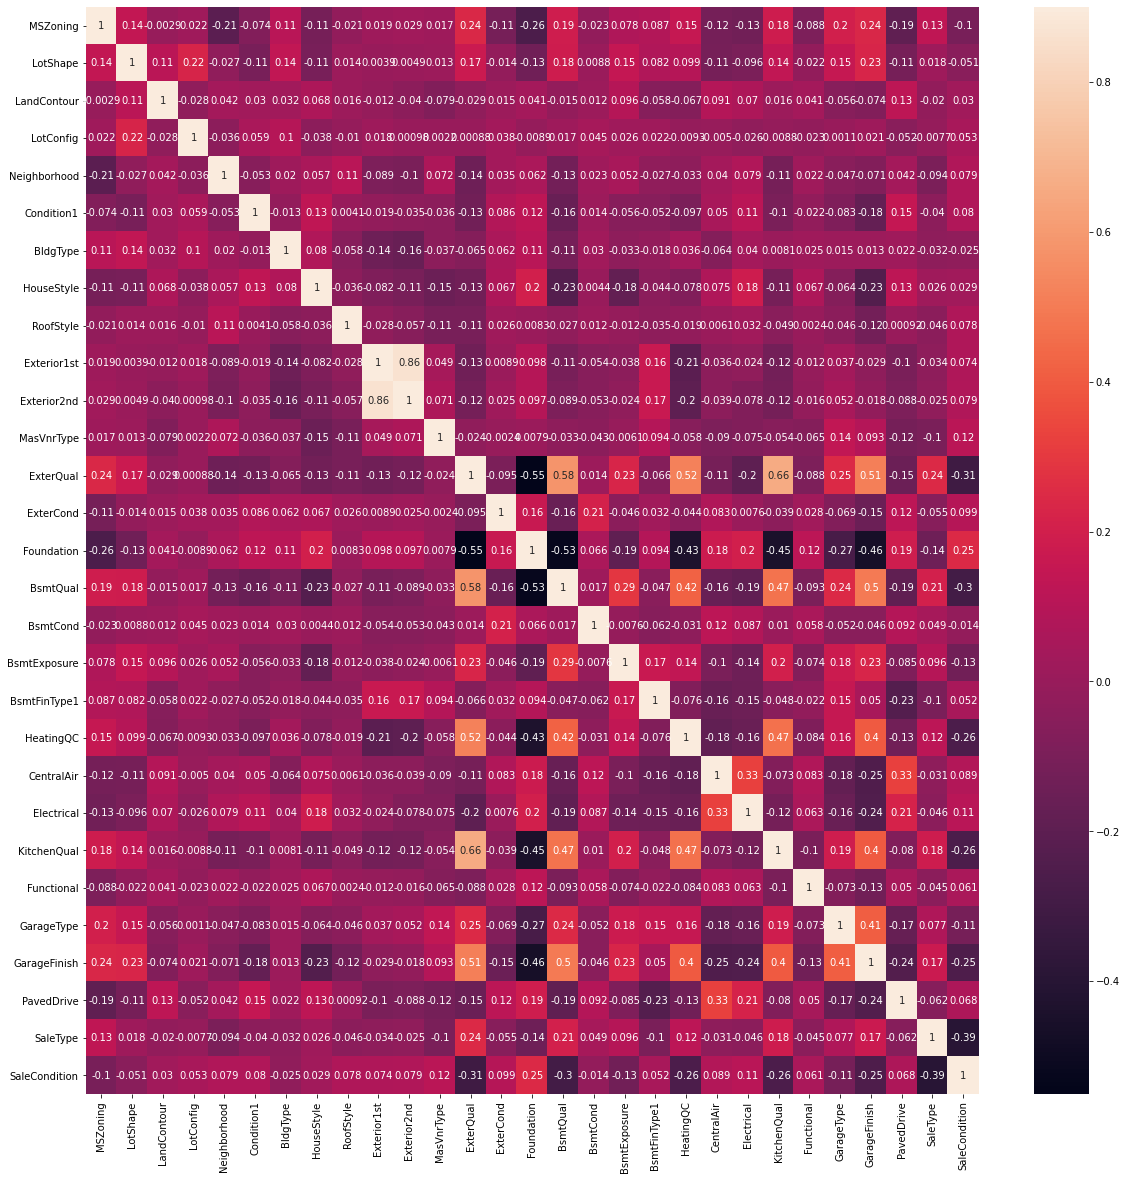

In [52]:
corr_matrix = df_for_corr[obj_features].corr('spearman')
f, ax1 = plt.subplots(figsize=(20,20)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, annot = True);

Correlation between numerical features

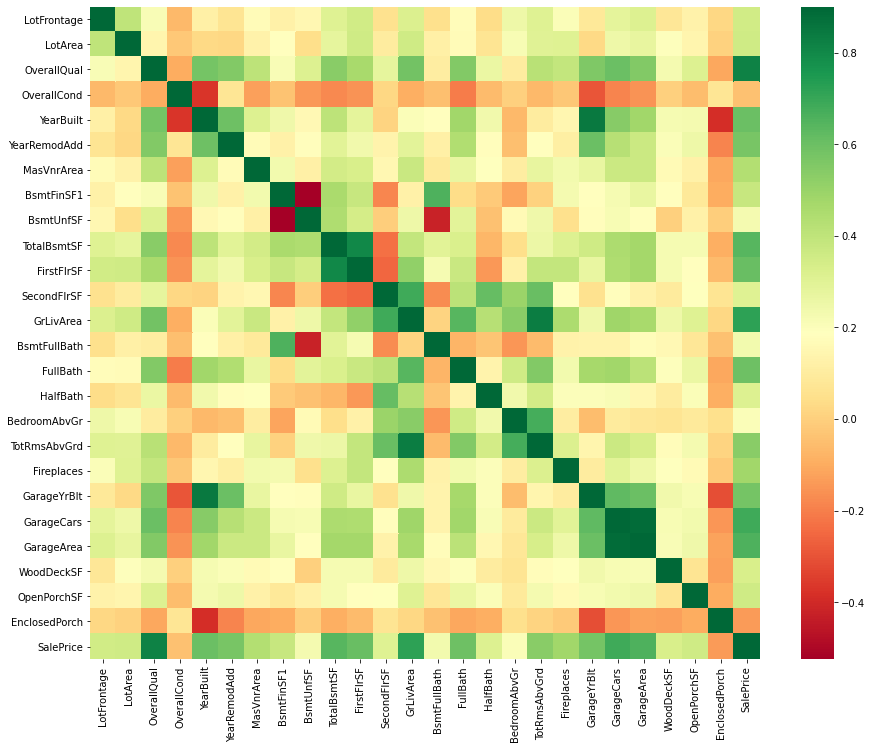

In [53]:
corr_matrix = df_for_corr[numerical_features].corr('spearman')
f, ax1 = plt.subplots(figsize=(15,12)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, cmap="RdYlGn"); 

<AxesSubplot:xlabel='GarageCars', ylabel='GarageArea'>

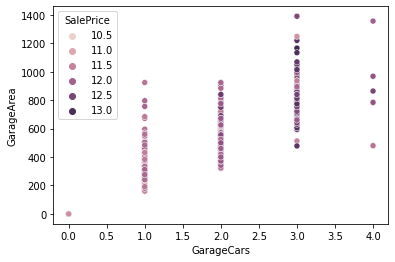

In [54]:
sns.scatterplot(data = df_for_learning_no_missing, x = 'GarageCars', y = 'GarageArea', hue = 'SalePrice')

In [55]:
def remove_correlated_features(df):
    columns_to_drop = ['GarageCars', 'FirstFlrSF', 'GarageYrBlt','GrLivArea']
    #columns_to_drop = ['GarageYrBlt','GarageArea','FirstFlrSF','BedroomAbvGr','BsmtFullBath','ExterQual','HeatingQC','BsmtQual']
    df.drop(columns = columns_to_drop, inplace = True)
    return df

# df_for_learning_no_missing = remove_correlated_features(df_for_learning_no_missing)
# df_for_test_no_missing = remove_correlated_features(df_for_test_no_missing)

In [56]:
df_for_learning_no_missing.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,SalePrice
count,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,...,1443.000000,1443.000000,1443.00000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000
mean,69.386694,9989.979903,6.085239,5.571726,1971.361053,1984.846847,100.762301,434.105336,567.844075,1048.376992,...,2.861400,6.500347,0.60499,1976.596674,1.765766,471.724879,93.201663,45.313929,21.963964,12.019890
std,19.868085,5298.546396,1.366966,1.112072,30.142874,20.641433,172.765965,428.293815,442.239359,411.169563,...,0.800607,1.599833,0.63685,26.253951,0.744294,211.103934,122.775040,61.802484,61.109575,0.392692
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.00000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.471950
25%,60.000000,7517.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.500000,795.000000,...,2.000000,5.000000,0.00000,1959.000000,1.000000,329.000000,0.000000,0.000000,0.000000,11.774520
50%,69.000000,9450.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,378.000000,480.000000,990.000000,...,3.000000,6.000000,1.00000,1978.000000,2.000000,478.000000,0.000000,24.000000,0.000000,11.995352
75%,79.000000,11506.000000,7.000000,6.000000,2001.000000,2004.000000,163.500000,705.500000,808.000000,1285.000000,...,3.000000,7.000000,1.00000,2001.000000,2.000000,576.000000,168.000000,67.500000,0.000000,12.269047
max,182.000000,70761.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,2188.000000,2336.000000,3206.000000,...,6.000000,12.000000,3.00000,2010.000000,4.000000,1390.000000,736.000000,418.000000,552.000000,13.345507


## Some preparations before train

In [57]:
df_for_learning_no_missing.describe

<bound method NDFrame.describe of      MSZoning  LotFrontage  LotArea LotShape LandContour LotConfig  \
0          RL         65.0     8450      Reg         Lvl    Inside   
1          RL         80.0     9600      Reg         Lvl       FR2   
2          RL         68.0    11250      IR1         Lvl    Inside   
3          RL         60.0     9550      IR1         Lvl    Corner   
4          RL         84.0    14260      IR1         Lvl       FR2   
...       ...          ...      ...      ...         ...       ...   
1455       RL         62.0     7917      Reg         Lvl    Inside   
1456       RL         85.0    13175      Reg         Lvl    Inside   
1457       RL         66.0     9042      Reg         Lvl    Inside   
1458       RL         68.0     9717      Reg         Lvl    Inside   
1459       RL         75.0     9937      Reg         Lvl    Inside   

     Neighborhood Condition1 BldgType HouseStyle  ...  GarageFinish  \
0         CollgCr       Norm     1Fam     2Story  ... 

In [58]:
df_for_learning_no_missing = df_for_learning_no_missing.reset_index(drop = True)
df_for_test_no_missing = df_for_test_no_missing.reset_index(drop = True)

## Data transfromation using StandardScaler, PCA and NonLinearTranformation

In [59]:
def get_StandardScaler(train_df):
    numerical_features = get_num_features_for_train(train_df)
    Scaler = StandardScaler()
    num_data = train_df[numerical_features]
    Scaler = StandardScaler().fit(num_data)
    return Scaler

In [60]:
def get_PCA_transformer(train_df, Scaler):
    numerical_features = get_num_features_for_train(train_df)
    pca = PCA(0.95)
    num_data = train_df[numerical_features]
    num_data = Scaler.transform(num_data)
    pca.fit(num_data)
    return pca

In [61]:
def pca_transform(df, pca_fitted_on_train):
    numerical_features = get_num_features_for_train(df)
    num_data = df[numerical_features]
    principalComponents = pca_fitted_on_train.transform(num_data)
    n_components = principalComponents.shape[1]
    pca_col_names = ["pca_{}".format(i+1) for i in range(n_components)]
    pca_data_frame = pd.DataFrame(data = principalComponents
             , columns = pca_col_names)
    df = df.drop(columns = numerical_features)
    df = pd.concat([df, pca_data_frame], axis = 1)
    return df

In [62]:
def scale_numerical_df(df, Scaler):
    numerical_features = get_num_features_for_train(df)
    #Scaler = RobustScaler()
    df[numerical_features] = Scaler.transform(df[numerical_features])
    return df

In [63]:
def get_isomap_transformer(train_df, std_scaler, pca_transformer):
    numerical_features = get_num_features_for_train(train_df)
    isomap = Isomap(n_components=3)
    num_data = train_df[numerical_features]
    num_data = std_scaler.transform(num_data)
    num_data = pca_transformer.transform(num_data)
    isomap.fit(num_data)
    return isomap

In [64]:
def isomap_transform(df, isomap_transformer):
    numerical_features = get_num_features_for_train(df)
    num_data = df[numerical_features]
    num_data = isomap_transformer.transform(num_data)
    isomap_col_names = ["isomap_{}".format(i+1) for i in range(3)]
    isomap_data_frame = pd.DataFrame(data = num_data
             , columns = isomap_col_names)
    df = df.drop(columns = numerical_features)
    df = pd.concat([df, isomap_data_frame], axis = 1)
    return df

Data Normalization (numerical features)

In [65]:
train_data, val_data, train_value, val_value = train_test_split(df_for_learning_no_missing.drop(columns = "SalePrice"), df_for_learning_no_missing.SalePrice, test_size = 0.2, random_state=2021 )

In [66]:
train_data.reset_index(drop = True, inplace = True)
val_data.reset_index(drop = True, inplace = True)
train_value.reset_index(drop = True, inplace = True)
val_value.reset_index(drop = True, inplace = True)

In [67]:
# df_for_test_no_missing = remove_nans_custom(df_for_test_no_missing)
# train_data = remove_nans_custom(train_data)
# val_data = remove_nans_custom(val_data)

In [68]:
train_data

,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,SaleType,SaleCondition
0,RL,65.0,10237,Reg,Lvl,Inside,Gilbert,RRAn,1Fam,2Story,...,2005.0,Fin,2,393,Y,0,72,0,New,Partial
1,RL,42.0,14892,IR1,HLS,CulDSac,Gilbert,Norm,1Fam,1Story,...,2006.0,Fin,3,758,Y,201,39,0,WD,Normal
2,RL,70.0,9100,Reg,Lvl,Inside,NAmes,Norm,1Fam,1Story,...,2008.0,Unf,1,300,Y,0,0,0,WD,Normal
3,RL,75.0,7950,IR1,Bnk,Corner,Edwards,Norm,1Fam,2Story,...,1977.0,Fin,2,440,Y,252,0,0,WD,Normal
4,RL,61.0,7930,Reg,Lvl,Inside,NAmes,Norm,1Fam,1Story,...,1969.0,RFn,2,440,Y,171,48,0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,RM,50.0,9000,Reg,Lvl,Corner,OldTown,Artery,1Fam,2Story,...,1937.0,Unf,1,240,N,0,0,293,WD,Abnorml
1150,RL,64.0,10475,IR1,Lvl,Corner,CollgCr,Norm,1Fam,1Story,...,2008.0,RFn,3,776,Y,160,33,0,WD,Normal
1151,RL,66.0,13682,IR2,HLS,CulDSac,StoneBr,Norm,1Fam,2Story,...,2006.0,Fin,3,641,Y,192,0,37,New,Partial
1152,RM,60.0,7200,Reg,Lvl,Corner,OldTown,Norm,1Fam,2Story,...,1989.0,Unf,2,576,N,36,0,221,WD,Normal


In [69]:
std_scaler = get_StandardScaler(train_data)
pca_transformer = get_PCA_transformer(train_data, std_scaler)
isomap_transformer = get_isomap_transformer(train_data, std_scaler, pca_transformer)

In [70]:
train_data = scale_numerical_df(train_data, std_scaler)
val_data = scale_numerical_df(val_data, std_scaler)
df_for_test_no_missing = scale_numerical_df(df_for_test_no_missing, std_scaler)

In [71]:
# train_data = pca_transform(train_data, pca_transformer)
# val_data = pca_transform(val_data, pca_transformer)
# df_for_test_no_missing = pca_transform(df_for_test_no_missing, pca_transformer)

In [72]:
# train_data = isomap_transform(train_data, isomap_transformer)
# val_data = isomap_transform(val_data, isomap_transformer)
# df_for_test_no_missing = isomap_transform(df_for_test_no_missing, isomap_transformer)

After PCA all numerical components become ortogonal

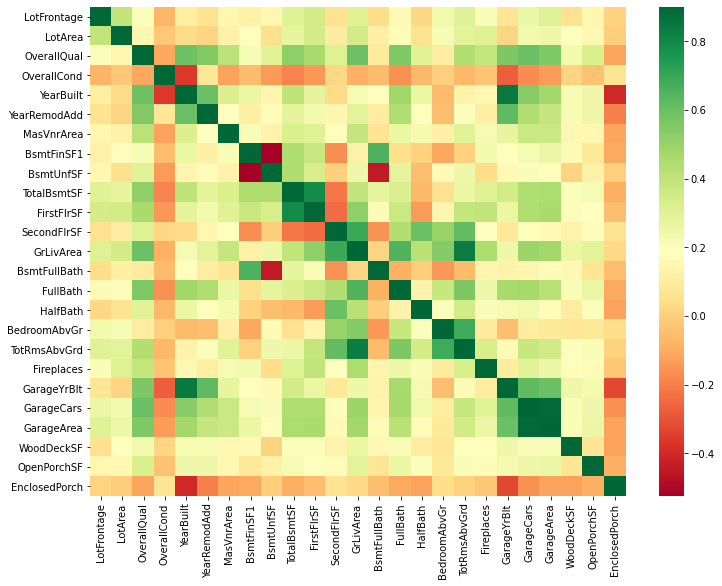

In [73]:
numerical_features  = list(train_data.select_dtypes(include=['int64','float64']).columns)
corr_matrix = train_data[numerical_features].corr('pearson')
f, ax1 = plt.subplots(figsize=(12,9)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, cmap="RdYlGn"); 

So we can see the target variable approximately disributed the same way between train and validation datasets

In [74]:
cat_features = list(df_for_learning_no_missing.select_dtypes(include=['object','bool']).columns)
train_pool = catboost.Pool(
    train_data,
    label=train_value,
    cat_features = cat_features
)
val_pool = catboost.Pool(
    val_data,
    label = val_value,
    cat_features = cat_features
)

In [75]:
catboost_train_dir = 'catboost_train_dir'
!rmdir /S /Q catboost_train_dir
!mkdir catboost_train_dir

In [76]:
regr_model = catboost.CatBoostRegressor(
    # early_stopping_rounds=20,
    random_seed=2021,
    depth = 5,
    od_pval=0.05,
    od_wait=20,
    loss_function='RMSE',
    #learning_rate=0.1,
    iterations = 3000,
    train_dir=catboost_train_dir,
    task_type='GPU',
    # task_type='CPU',
    # devices='0',
    #auto_class_weights='Balanced',
    max_ctr_complexity=4,
    l2_leaf_reg = 1,
    use_best_model=True
)
regr_model.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp'
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3922459	test: 0.3663574	best: 0.3663574 (0)	total: 63.9ms	remaining: 3m 11s
1:	learn: 0.3870988	test: 0.3610842	best: 0.3610842 (1)	total: 130ms	remaining: 3m 14s
2:	learn: 0.3821418	test: 0.3562057	best: 0.3562057 (2)	total: 192ms	remaining: 3m 11s
3:	learn: 0.3773593	test: 0.3514547	best: 0.3514547 (3)	total: 258ms	remaining: 3m 13s
4:	learn: 0.3728070	test: 0.3469750	best: 0.3469750 (4)	total: 331ms	remaining: 3m 18s
5:	learn: 0.3684589	test: 0.3426443	best: 0.3426443 (5)	total: 394ms	remaining: 3m 16s
6:	learn: 0.3638792	test: 0.3383803	best: 0.3383803 (6)	total: 458ms	remaining: 3m 15s
7:	learn: 0.3599813	test: 0.3346983	best: 0.3346983 (7)	total: 520ms	remaining: 3m 14s
8:	learn: 0.3561618	test: 0.3310406	best: 0.3310406 (8)	total: 586ms	remaining: 3m 14s
9:	learn: 0.3526524	test: 0.3275115	best: 0.3275115 (9)	total: 661ms	remaining: 3m 17s
10:	learn: 0.3491490	test: 0.3240452	best: 0.3240452 (10)	total: 736ms	remaining: 3m 20s
11:	learn: 0.3456324	test: 0.3208240	bes

94:	learn: 0.2056433	test: 0.1916815	best: 0.1916815 (94)	total: 7.9s	remaining: 4m 1s
95:	learn: 0.2049792	test: 0.1911423	best: 0.1911423 (95)	total: 8.06s	remaining: 4m 3s
96:	learn: 0.2042757	test: 0.1904465	best: 0.1904465 (96)	total: 8.14s	remaining: 4m 3s
97:	learn: 0.2036519	test: 0.1898144	best: 0.1898144 (97)	total: 8.22s	remaining: 4m 3s
98:	learn: 0.2029644	test: 0.1892209	best: 0.1892209 (98)	total: 8.3s	remaining: 4m 3s
99:	learn: 0.2023432	test: 0.1885905	best: 0.1885905 (99)	total: 8.39s	remaining: 4m 3s
100:	learn: 0.2016976	test: 0.1880841	best: 0.1880841 (100)	total: 8.47s	remaining: 4m 3s
101:	learn: 0.2006203	test: 0.1871084	best: 0.1871084 (101)	total: 8.57s	remaining: 4m 3s
102:	learn: 0.2000316	test: 0.1866494	best: 0.1866494 (102)	total: 8.65s	remaining: 4m 3s
103:	learn: 0.1993679	test: 0.1861709	best: 0.1861709 (103)	total: 8.73s	remaining: 4m 3s
104:	learn: 0.1983139	test: 0.1850467	best: 0.1850467 (104)	total: 8.82s	remaining: 4m 3s
105:	learn: 0.1977298	te

limit_output extension: Maximum message size of 10000 exceeded with 10070 characters

Write SalePrice prediction for test values in file

In [82]:
df_to_csv = pd.DataFrame()
df_to_csv['SalePrice'] = regr_model.predict(df_for_test_no_missing)
df_to_csv['SalePrice'] = np.exp(df_to_csv['SalePrice'])
df_to_csv['Id'] = df_test_id
df_to_csv.to_csv('answer.csv', index = False)

## Post-Hoc analysis

In [83]:
features_importance = sorted(
    zip(train_data.columns, regr_model.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)
important_features_cumulative = np.cumsum([feature[1] for feature in features_importance], axis = 0)
features_importance = pd.DataFrame(features_importance)
features_importance.columns = ['Feature','Feature_importance']
features_importance['Cumulative_sum'] = important_features_cumulative
features_importance['CorrWithSalePrice'] = [stats.spearmanr(train_value, train_data[feature])[0]
                                            for feature in features_importance['Feature']]
features_importance

,Feature,Feature_importance,Cumulative_sum,CorrWithSalePrice
0,Neighborhood,20.412804,20.412804,0.174864
1,GrLivArea,18.958772,39.371576,0.738500
2,OverallQual,14.354393,53.725970,0.810290
3,KitchenQual,4.471157,58.197126,-0.562484
4,Exterior2nd,4.179932,62.377058,0.063554
5,BsmtFinSF1,3.839297,66.216355,0.299815
6,Exterior1st,3.611570,69.827926,0.054356
7,TotalBsmtSF,3.275807,73.103733,0.593337
8,ExterQual,2.747945,75.851677,-0.630001
9,LotArea,2.717604,78.569281,0.455703


As we can see many important feautres also have strong correlation with the SalePrice, except NeigborHood (maybe because it is a categorical feature)

In [79]:
shap_info = regr_model.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]

Processing trees...
128/1578 trees processed	passed time: 18.5ms	remaining time: 210ms
1578/1578 trees processed	passed time: 162ms	remaining time: 0us
Processing documents...
128/1154 documents processed	passed time: 21.8ms	remaining time: 175ms
1154/1154 documents processed	passed time: 199ms	remaining time: 0us


In [80]:
shap_values.shape

(1154, 54)

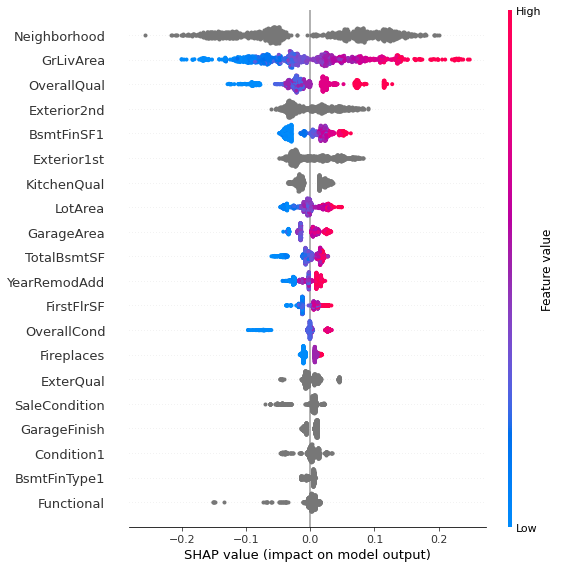

In [81]:
shap.summary_plot(shap_values, train_data)